In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, splprep, splev

In [180]:
"""
    Trajectory class:
    -Implements pth order B-Spline trajectory with k smoothness constraints
    -Eg. order k=3 is v_i(t)=v_{i+1}(t) and a_i(t)=a_{i+1}(t) at each node
    -Min jerk is order k=4, min snap is order k=5
    -Zero boundary conditions at the start/end node always assumed
"""
class BSplineTrajectory:
    """
        bc_type=([bcs at x[0]], [bcs at x[-1]])
        bc="clamped": 1st derivatives ==
        bc="natural": 1st & 2nd derivatives are ==
        bc="natural2": ([(1,0.0),(2,0.0)],[(1,0.0),(2,0.0)])
    """
    def __init__(self, setpoints, order=3, bc='natural2'):
        #state params
        self.computed = False
        self.updated = False

        #define points as: [[x...],[y...]]
        self.setpoints = setpoints

        #define params
        self.order = order
        if bc == "natural" or bc == "clamped":
            self.bc = bc
        else:
            self.bc = ([(1,0.0),(2,0.0)],[(1,0.0),(2,0.0)])

        #define splines
        self.spline = None
        self.vspline = None
        self.aspline = None

        #define sampling params
        self.min = 0
        self.max = 0
        self.n = 0

        #define samples
        self.samples = None
        self.vsamples = None
        self.asamples = None

    def isPeriodic(self):
        return self.setpoints[0,0] == self.setpoints[-1,0] and self.setpoints[0,1] == self.setpoints[-1,1]

    #compute specified B-Spline
    def compute(self):
        #fit b-spline: needs testing
        '''
        self.spline = make_interp_spline(
            self.setpoints[:,0], 
            self.setpoints[:,1], 
            k=self.order, 
            bc_type=self.bc
        )
        '''
        #w/o boundary conditions: (knots, parameters)
        self.spline = splprep([self.setpoints[:,0], self.setpoints[:,1]], s=0, per=self.isPeriodic())

        #update state
        if self.computed: 
            self.updated = True
        else:
            self.computed = True

    #Sample B-Spline along linspace
    def sample(self, n):
        #Compute spline if it doesn't exist
        if not self.computed:
            self.compute()

        #check if new samples needed: (never sampled AND not updated) OR new params
        needNewSamples = self.n is not n or not self.samples or self.updated
        if not needNewSamples:
            return self.samples

        #get linspace and samples
        self.x = np.linspace(0,1,n)
        x, y = splev(self.x, self.spline[0])
        self.samples = np.array([x,y]).T
        #self.samples = self.spline(self.x)

        #reset update if needed
        if self.updated:
            self.updated = False

        return self.samples

    #Plot trajectory
    def plot(self, ax=plt, title="B-Spline Trajectory", xlabel="x", ylabel="y"):
        ax.plot(self.samples[:,0], self.samples[:,1],color='orange')
        ax.title(title)
        ax.xlabel(xlabel)
        ax.ylabel(ylabel)

    #Plot trajectory, velocity, and acceleration
    def plotPVA(self, ax=plt, titles="B-Spline Trajectory", xlabels=["x","x","x"], ylabels=["y","y'","y''"]):
        fig, (axp, axv, axa) = ax.subplots(1, 3)
        fig.suptitle('Trajectory Position, Velocity, and Acceleration')

        #compute velocity and sample
        if self.updated: #or not self.vspline:
            #self.vspline = self.spline.derivative(1)
            self.aamples = self.splev(self.x, self.spline[0], der=1)

        #compute acceleration and sample
        if self.updated: #or not self.aspline:
            #self.aspline = self.vspline.derivative(1)
            self.asamples = self.splev(self.x, self.spline[0], der=2)

        #plot position
        self.plot(axp, titles[0], xlabels[0], ylabels[0])

        #plot velocity
        axv.plot(self.vsamples[:,0], self.vsamples[:,1])
        axv.title(titles[1])
        axv.xlabel(xlabels[1])
        axv.ylabel(ylabels[1])

        #plot acceleration
        axa.plot(self.asamples[:,0], self.asamples[:,1])
        axa.title(titles[2])
        axa.xlabel(xlabels[2])
        axa.ylabel(ylabels[2])

In [181]:
"""
    Waypoints class
       -Sample and resample B-Spline Trajectory with arbitrary precision
       -Step forward or backwards along trajectory as needed
       -check for last waypoint in trajectory
"""
class Waypoints:
    def __init__(self, trajectory, n):
        #input trajectory and sample
        self.trajectory = trajectory
        self.samples = self.trajectory.sample(n)
        self.loop = self.isLoop()

        #State
        self.current = 0
        self.filename = None

    #import from file
    def __call__(self, filename):
        #State
        self.current = 0
        self.filename = None

        #get trajectory
        self.load(filename)

    #save trajectory as pickle
    def save(self, filename):
        with open(filename, 'wb') as file:
            np.save(file, self.samples, True)
    
    #load pickled trajectory
    def load(self, filename):
        with open(filename, 'rb') as file:
            self.samples = np.load(file)

    #check for loop
    def isLoop(self):
        return self.samples[0,0] == self.samples[-1,0] and self.samples[0,1] == self.samples[-1,1]

    #Reample B-Spline along linspace
    def resample(self, n):
        if self.trajectory:
            #sample
            self.samples = self.trajectory.sample(n)

            #reset state
            self.current = 0

    #Check if current waypoint is last
    def isLast(self):
        if self.current == len(self.samples):
            return True
        else:
            return False

    #Goto next waypoint and return current sample
    def step(self):
        self.current += 1
        return self.samples[self.current]
    
    #Return next waypoint
    def next(self):
        return self.samples[self.current + 1]

    #Goto previous waypoint and return current sample
    def backstep(self):
        self.current -= 1
        return self.samples[self.current]

    #Plot Sampled trajectory
    def plot(self, ax=plt, title="Waypoints", xlabel="x", ylabel="y", color="blue"):
        n = -1 if self.isLoop() else len(self.samples) 
        ax.scatter(self.samples[:n,0], self.samples[:n,1], color=color)
        ax.title(title)
        ax.xlabel(xlabel)
        ax.ylabel(ylabel)

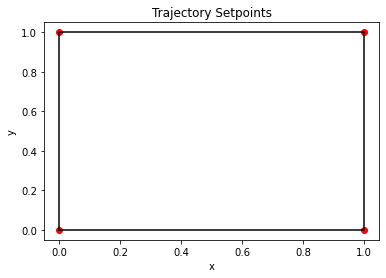

In [182]:
#Checks for loop and then plots
def plotPoints(ax, points, title, xlabel, ylabel):
    #check for loop
    n = -1 if (points[0,0] == points[-1,0] and points[0,1] == points[-1,1]) else len(points)

    #plot points
    ax.plot(points[:,0], points[:,1], color='black')
    ax.scatter(points[:n,0], points[:n,1], color='red')
    ax.title(title)
    ax.xlabel(xlabel)
    ax.ylabel(ylabel)

#Draw square and plot waypoints (corners)
setpoints = np.array([[0,0],[0,1],[1,1],[1,0],[0,0]])
plotPoints(plt, setpoints, "Trajectory Setpoints", "x", "y")

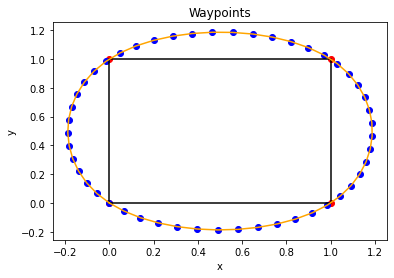

In [183]:
#Compute minimum acceleration trajectory w/ k=3
trajectory = BSplineTrajectory(setpoints)
waypoints = Waypoints(trajectory, 50)

plotPoints(plt, setpoints, "Trajectory Setpoints", "x", "y")
trajectory.plot()
waypoints.plot()

#display trajectory, velocity, acceleration plots

#display waypoints


In [184]:
#Compute minimum snap trajectory w/ k=5


#display trajectory, velocity, acceleration plots